In [1]:
import glob
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylib import *
plt.style.use('crisprhva.mplstyle')

In [2]:
def count(path, k):
    df = Counter(path, k).to_df(norm=False)
    df = df[df['seq'].apply(isvalidnt)]
    df['count'] /= np.sum(df['count'])
    df.set_index('seq', inplace=True)
    return df

In [3]:
taxids = [562, 287, 28901]
names = {
    562 : 'E. coli',
    287 : 'S. enterica',
    28901 : 'P. aeruginosa'
    }

In [4]:
for taxid in taxids:
    phagefile = datadir + 'filtered/phages_taxid{taxid}_filtered_rep_seq.fasta'.format(taxid=taxid)
    hostfile = datadir + '{taxid}_0.fna.gz'.format(taxid=taxid)
    print(names[taxid], '%e'%np.sum(load_fasta_as_df(phagefile)['sequence'].apply(len)),
         '%e'%np.sum(load_fasta_as_df(hostfile)['sequence'].apply(len)),
          '%g'%load_fasta_as_df(phagefile).shape[0])

E. coli 6.584377e+07 5.153453e+06 726
S. enterica 1.924319e+07 6.447478e+06 285
P. aeruginosa 3.125894e+07 4.786576e+06 380


In [5]:
probss = {}
for taxid in taxids:
    phagefile = datadir + 'filtered/phages_taxid{taxid}_filtered_rep_seq.fasta'.format(taxid=taxid)
    hostfile = datadir + '{taxid}_0.fna.gz'.format(taxid=taxid)

    k = 6
    df_phage = count(phagefile, k)
    df = count(hostfile, k)

    coincidence_probs =[] 
    for l in range(1, k):
        seqs = list(''.join(item) for item in itertools.product('ACGT', repeat=l))
        freq = []
        freq_phage = []
        for seq in seqs:
            freq.append(df[df.index.str.startswith(seq)]['count'].sum())
            freq_phage.append(df_phage[df_phage.index.str.startswith(seq)]['count'].sum())
        freq = np.array(freq)
        freq_phage = np.array(freq_phage)
        print(l, np.sum(freq*freq_phage)*4**l)
        coincidence_probs.append(np.sum(freq*freq_phage)*4**l)
    coincidence_probs.append(np.sum(df['count']*df_phage['count']*4**k))
    coincidence_probs = np.asarray(coincidence_probs)
    probss[taxid] = coincidence_probs

1 0.998092674639669
2 1.0095505477448832
3 1.0318253342901065
4 1.062424153099832
5 1.09744569931262
1 1.0223116541928239
2 1.0546057594204272
3 1.1077914631284793
4 1.1892084649870884
5 1.2813991214387155
1 0.995057415988816
2 1.000840825876321
3 1.0179300786487935
4 1.0435376014792834
5 1.0740369607684235


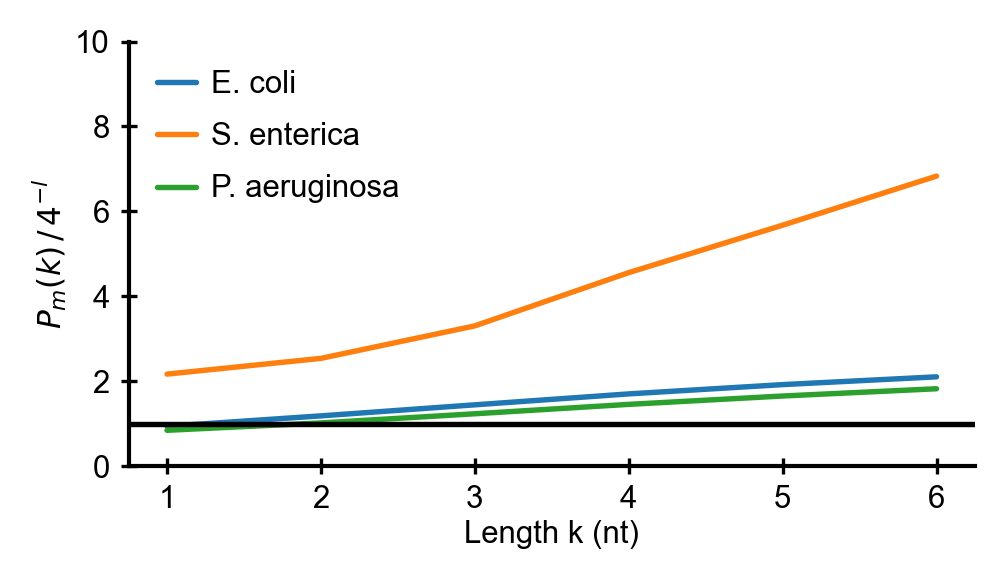

In [6]:
spacerlength = 35
l = np.arange(1, k+1)
fig, ax = plt.subplots(figsize=(3.42, 2.0))
for taxid in taxids:
    ax.plot(l, (probss[taxid]/4**l)**(spacerlength/l)*4**spacerlength, label=names[taxid])
ax.set_ylabel('$P_m(k) \, /\, 4^{-l}$')
ax.set_xlabel('Length k (nt)')
ax.legend(loc='upper left')
ax.axhline(1.0, c='k')
ax.set_ylim(0.0, 10.0)
fig.tight_layout()